In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [2]:
df = pd.read_csv("mathe_dataset.csv", sep=";", encoding="ISO-8859-1")

In [3]:
df['Keywords'] = df['Keywords'].str.split(',')

In [4]:
df.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."


# Clustering Problem: Finding the Topic Clusters

- Given the features: `Subtopic, Question Level, Keywords, and Student Country`, identify the Topic clusters.
- We apply the Clustering algorithms:
    - K-Means
    - Gaussian Mixture Model
    - Hierarchical (Agglomerative)

### Pre-processing

- Convert Student Country, Subtopic and Question Level to One-hot-encoding using Multi-label Binarier.
- Get the Tf-Idf vectors for keywords, as illustrated in Classification and Regression notebooks.

In [5]:
multi_label_cols = ['Subtopic', 'Question Level', 'Student Country']
preproc_df = df.copy()

for col in multi_label_cols:
    preproc_df[col] = preproc_df[col].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(preproc_df[col])
    preproc_df = preproc_df.join(pd.DataFrame(encoded, columns=[f"{col}_{cls}".replace(" ", "_").replace(",", "_") for cls in mlb.classes_]))
    preproc_df.drop(columns=[col], inplace=True)

In [6]:
vectorizer = TfidfVectorizer(max_features=100)
preproc_df['Keywords'] = preproc_df['Keywords'].apply(lambda x: ' '.join(x))
keywords_tfidf = vectorizer.fit_transform(preproc_df['Keywords']).toarray()

In [7]:
keywords_df = pd.DataFrame(keywords_tfidf, columns=[f"keyword_{i}" for i in range(keywords_tfidf.shape[1])])
preproc_df = preproc_df.drop(columns=['Keywords']).reset_index(drop=True)
preproc_df = pd.concat([preproc_df, keywords_df], axis=1)

In [8]:
preproc_df.head()

,Student ID,Question ID,Type of Answer,Topic,Subtopic_Algebraic_expressions,Subtopic_Analytic_Geometry,Subtopic_Complex_Numbers,Subtopic_Definite_Integrals,Subtopic_Derivatives,Subtopic_Differential_Equations,...,keyword_90,keyword_91,keyword_92,keyword_93,keyword_94,keyword_95,keyword_96,keyword_97,keyword_98,keyword_99
0,647,77,0,Statistics,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,41,77,1,Statistics,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,340,77,1,Statistics,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,641,77,0,Statistics,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,669,77,1,Statistics,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Student ID, Question ID are not required here
preproc_df = preproc_df.drop(["Student ID", "Question ID"], axis=1)

### Separate the original topics in the data, to further evaluate the clustering models once created.

In [10]:
label_encoder = LabelEncoder()
topic_encoded = label_encoder.fit_transform(preproc_df['Topic'])
topic_encoded_flat = topic_encoded.ravel()

In [11]:
df_encoded = preproc_df.drop(columns=['Topic'])

In [12]:
df_encoded.head()

,Type of Answer,Subtopic_Algebraic_expressions,Subtopic_Analytic_Geometry,Subtopic_Complex_Numbers,Subtopic_Definite_Integrals,Subtopic_Derivatives,Subtopic_Differential_Equations,Subtopic_Domain,Subtopic_Double_Integration,Subtopic_Eigenvalues_and_Eigenvectors,...,keyword_90,keyword_91,keyword_92,keyword_93,keyword_94,keyword_95,keyword_96,keyword_97,keyword_98,keyword_99
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Since the number of features are 138, we try to reduce the number of features to 2, in order to avoid the "curse of dimensionality".

In [13]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Apply PCA to reduce dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

### K-Means

In [14]:
kmeans = KMeans(n_clusters=14, random_state=42)
df_encoded['Cluster'] = kmeans.fit_predict(X_pca)

In [15]:
# Calculate ARI between clusters and "Question Level"
ari_score = adjusted_rand_score(topic_encoded_flat, df_encoded['Cluster'])
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Adjusted Rand Index (ARI): 0.2619


In [16]:
# Calculate NMI between clusters and "Question Level"
nmi_score = normalized_mutual_info_score(topic_encoded_flat, df_encoded['Cluster'])
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

Normalized Mutual Information (NMI): 0.4257


In [17]:
sil_score = silhouette_score(X_pca, df_encoded['Cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.497


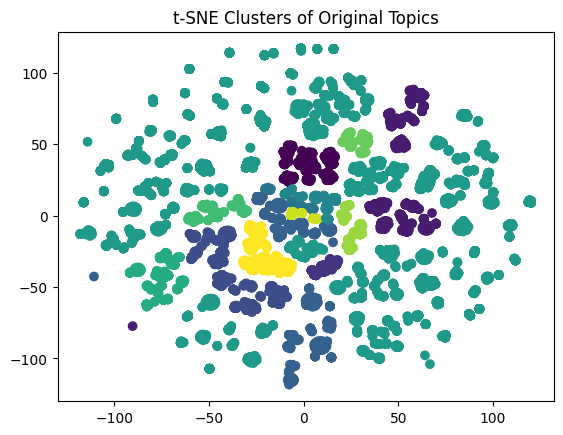

In [18]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(df_encoded.drop(columns='Cluster').values)

# Plot t-SNE results
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=topic_encoded_flat, cmap='viridis')
plt.title("t-SNE Clusters of Original Topics")
plt.show()

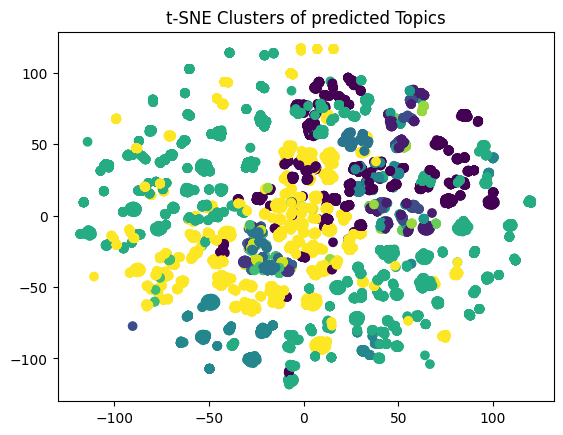

In [19]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(df_encoded.drop(columns='Cluster').values)

# Plot t-SNE results
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=df_encoded["Cluster"].astype('category').cat.codes, cmap='viridis')
plt.title("t-SNE Clusters of predicted Topics")
plt.show()

## GMM

In [20]:
gmm = GaussianMixture(n_components=14, random_state=42)
df_encoded['Cluster_GMM'] = gmm.fit_predict(X_pca)

In [21]:
# Calculate ARI between clusters and "Question Level"
ari_score = adjusted_rand_score(topic_encoded_flat, df_encoded['Cluster_GMM'])
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Adjusted Rand Index (ARI): 0.2240


In [22]:
# Calculate NMI between clusters and "Question Level"
nmi_score = normalized_mutual_info_score(topic_encoded_flat, df_encoded['Cluster_GMM'])
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

Normalized Mutual Information (NMI): 0.4393


In [23]:
silhouette = silhouette_score(X_pca, df_encoded['Cluster_GMM'])
silhouette

np.float64(0.4058640824777146)

## Hierarchical Clustering

In [24]:
agg_clustering = AgglomerativeClustering(n_clusters=14)
df_encoded["Cluster_Agglomerative"] = agg_clustering.fit_predict(X_pca)

In [25]:
# Calculate ARI between clusters and "Question Level"
ari_score = adjusted_rand_score(topic_encoded_flat, df_encoded['Cluster_Agglomerative'])
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Adjusted Rand Index (ARI): 0.3328


In [26]:
# Calculate NMI between clusters and "Question Level"
nmi_score = normalized_mutual_info_score(topic_encoded_flat, df_encoded['Cluster_Agglomerative'])
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

Normalized Mutual Information (NMI): 0.4456


In [27]:
silhouette = silhouette_score(X_pca, df_encoded['Cluster_Agglomerative'])
silhouette

np.float64(0.4821170211197841)